In [192]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import math
from pennylane.optimize import AdamOptimizer
import sys


In [193]:
#Global Control Variables
k_helper = None
k_full_global_search_max = None
k_full_global_search_min = None
k_binary_global_search_max = None
k_binary_global_search_min = None



# np.random.seed(42)
test_input = [0.6, 0.3, 0.0, 0.1, 0.5, 0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.0, 0.0, 0.0]
# test_input = np.random.rand(2**4)

num_of_qubits_test = int(np.log2(len(test_input)))
num_overflow_bit = 2

threshold_helper_u = 0.25
threshold_helper_l = -0.25

threshold_max = -0.8
threshold_min = 0.8




In [194]:
# Calculate global maximum and minimum (classical) for test purposes
cls_max_val = -2**num_of_qubits_test
cls_min_val = 2**num_of_qubits_test
invalid_state = '1'+(num_of_qubits_test-1)*'0'
invalid_state_index = 2**(num_of_qubits_test-1)

if(test_input[invalid_state_index]>0.00001):
    print('Oracle has invalid state -0')

for x in range(len(test_input)):
    if(np.isclose(test_input[x],0) or x==invalid_state_index):
        continue
    bin_rep = np.binary_repr(x,num_of_qubits_test)
    if(bin_rep[0]=='1'):
        x=int(bin_rep,2)-(1<<num_of_qubits_test)
    if(x<cls_min_val):
        cls_min_val=x
    if(x>cls_max_val):
        cls_max_val=x

print(cls_max_val)
print(cls_min_val)


Oracle has invalid state -0
7
-7


In [195]:
def add_k_sign(k, wires):
    #sign handling
    bin_rep = np.binary_repr(k,len(wires))
    k = int(bin_rep,2)

    qml.QFT(wires=wires)
    for j in range(len(wires)):
        qml.RZ(k * np.pi / (2**j), wires=wires[j])
    qml.adjoint(qml.QFT)(wires=wires)

In [196]:
num_qubits = num_of_qubits_test + num_overflow_bit


num_of_qubits_vqs = num_qubits + 1
eps_val_q = 1/math.sqrt(2**num_of_qubits_vqs)/100
eps_val = min(1e-10, eps_val_q)
tiny_change_threshold = 1e-4
cnt_threshold_no_change = 5


start_state = np.array(test_input)
start_state = start_state/np.linalg.norm(start_state)

initial_state2 = start_state.tolist()

initial_state_phi1 = initial_state2
print(f'initial_state_phi1={initial_state_phi1}')
initial_state_0_phi1  = initial_state_phi1 + [0]*len(initial_state_phi1) # 2**num_of_qubits

initial_state_phi1=[0.240932721757057, 0.07433260904056538, 0.36712767744661484, 0.03362483657126315, 0.35956205380940015, 0.3189766722099885, 0.3518392929630435, 0.37109095367303696, 0.12672397597786333, 0.25858929724895685, 0.08531154109752932, 0.04106242978024754, 0.0919401906917001, 0.2954037927187315, 0.32621764163090455, 0.11813734236968004]


In [197]:
device_name_standard_maker = 'default.qubit'
device_global_search = 'default.qubit' 
device_name3 = 'default.qubit' 




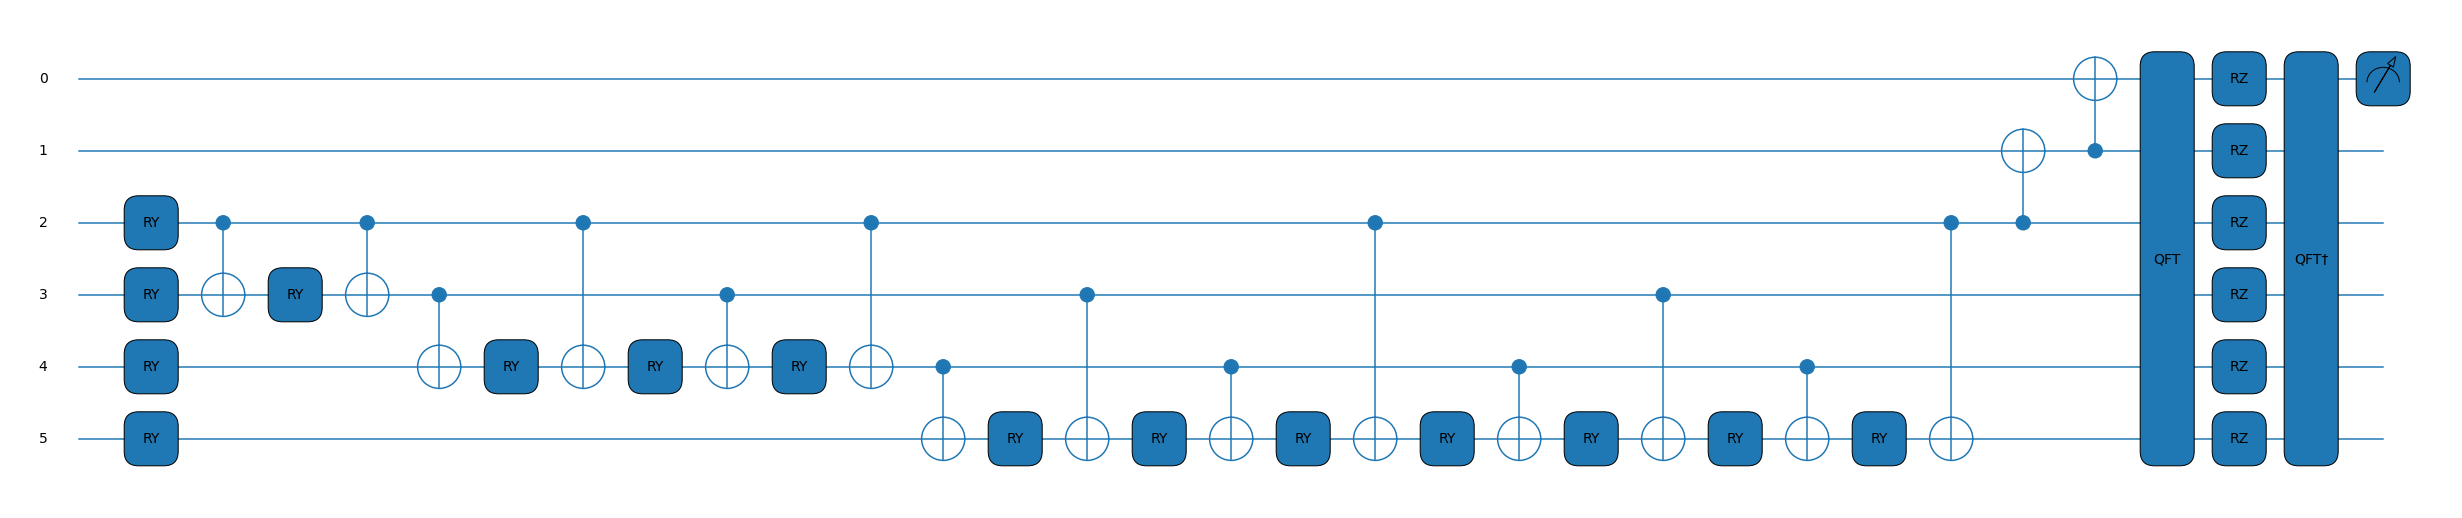

In [198]:
dev_standard_maker = qml.device(device_name_standard_maker, wires=num_qubits,shots=1024) 
@qml.qnode(dev_standard_maker)
def standard_maker_helper_circuit(k,input,wires):
    qml.QubitStateVector(np.array(input), wires=wires[num_overflow_bit:])
     # add some bits for handle overflow
    for w in reversed(range(1,num_overflow_bit+1)):
        qml.CNOT([w,w-1])
    add_k_sign(k,wires=wires)
    return qml.expval(qml.PauliZ(wires=0))


qml.draw_mpl(standard_maker_helper_circuit, show_all_wires=True)(0,start_state,dev_standard_maker.wires)
plt.show()

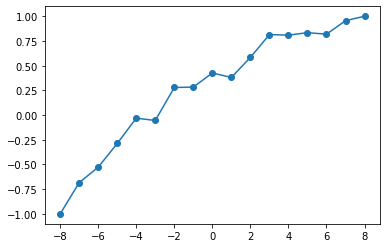

In [199]:

# x=[i for i in range(-2**(num_qubits-1-1),2**(num_qubits-1-1)+1)]
x=[i for i in range(-(2**(num_of_qubits_test-1)),2**(num_of_qubits_test-1)+1)]
y=[]
for i in x:
    exp_val = standard_maker_helper_circuit(i,start_state,dev_standard_maker.wires) 
    if(threshold_helper_l<exp_val<threshold_helper_u):
        # print(i)
        k_helper = i

    y.append(exp_val)

# plot scatter plot with x and y data
plt.scatter(x, y)
  
# plot with x and y data
plt.plot(x, y)

if(k_helper==None):
    print('Error in standard making')



In [200]:
dev_global_search = qml.device(device_global_search, wires=num_qubits,shots=1024) 
@qml.qnode(dev_global_search)
def global_search(k_new,k_helper,input,wires):
    qml.QubitStateVector(np.array(input), wires=wires[num_overflow_bit:])
    # add some bits for handle overflow
    for w in reversed(range(1,num_overflow_bit+1)):
        qml.CNOT([w,w-1])     
    add_k_sign(k_helper+k_new,wires=wires)
    return qml.expval(qml.PauliZ(wires=0))

In [201]:
# Full Global Search
size = 2**(num_qubits-num_overflow_bit)-1

plt_x_max=[i for i in reversed(range(-size,1))]
plt_y_max = []

plt_x_min = [i for i in range(0,size+1)]
plt_y_min = []

i_max=0
i_min=0

fmax_flag = False
while i_max<=size:
    exp_val = global_search(-i_max,k_helper,start_state,dev_global_search.wires)
    plt_y_max.append(exp_val)
    if(threshold_max>exp_val and not fmax_flag):
        k_full_global_search_max = -i_max
        fmax_flag = True
    i_max+=1

        
fmin_flag = False       
while i_min<=size:
    exp_val = global_search(i_min,k_helper,start_state,dev_global_search.wires) 
    plt_y_min.append(exp_val)
    if(exp_val>threshold_min and not fmin_flag):
        k_full_global_search_min = i_min
        fmin_flag = True
    i_min += 1


k_helper =  -3
k_full_global_search_max=  -5
k_full_global_search_min=  9
Quantum Solution for Max (without VQS) =  8
Quantum Solution for Min (without VQS) =  -6
Classical Solution for Max:  7
Classical Solution for Min:  -7


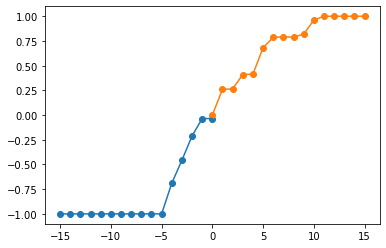

In [202]:
plt.scatter(plt_x_max, plt_y_max)
plt.plot(plt_x_max, plt_y_max)


plt.scatter(plt_x_min, plt_y_min)
plt.plot(plt_x_min, plt_y_min)


if k_full_global_search_max == None:
    print('Error in finding global max')
if k_full_global_search_min == None:
    print('Error in finding global min')

    
print('k_helper = ',k_helper)
print('k_full_global_search_max= ',k_full_global_search_max)
print('k_full_global_search_min= ',k_full_global_search_min)


q_max_val = -(k_helper+k_full_global_search_max)
q_min_val = -(k_helper+k_full_global_search_min)

print('=========================================')
print('Quantum Solution for Max (without VQS) = ',q_max_val)
print('Quantum Solution for Min (without VQS) = ',q_min_val)

print('Classical Solution for Max: ',cls_max_val)
print('Classical Solution for Min: ',cls_min_val)

In [203]:
# Binary Search
size = 2**(num_qubits-num_overflow_bit)-1


i_max=0
i_min=0



while k_binary_global_search_max==None:
    exp_val = global_search(-i_max,k_helper,start_state,dev_global_search.wires)
    if(threshold_max>exp_val):
        k_binary_global_search_max = -i_max
    else:
        i_max += int((size-i_max)/2)

             
while k_binary_global_search_min==None:
    exp_val = global_search(i_min,k_helper,start_state,dev_global_search.wires) 
    if(exp_val>threshold_min):
        k_binary_global_search_min = i_min
    else:
        i_min += int((size-i_min)/2)


if k_binary_global_search_max == None:
    print('Error in finding global max binary')
if k_binary_global_search_min == None:
    print('Error in finding global min binary')

    
print('k_helper= ',k_helper)
print('k_binary_global_search_max= ',k_binary_global_search_max)
print('k_binary_global_search_min= ',k_binary_global_search_min)

qbs_max_val = -(k_helper+k_binary_global_search_max)
qbs_min_val = -(k_helper+k_binary_global_search_min)

print('=========================================')
print('Quantum Solution for Max= ',q_max_val)
print('Quantum Solution for Min= ',qbs_min_val)

print('Classical Solution for Max: ',cls_max_val)
print('Classical Solution for Min: ',cls_min_val)

k_helper=  -3
k_binary_global_search_max=  -7
k_binary_global_search_min=  7
Quantum Solution for Max=  8
Quantum Solution for Min=  -4
Classical Solution for Max:  7
Classical Solution for Min:  -7
